# 1) Project Overview

Goal: Predict Airbnb nightly prices in Texas and identify the strongest price drivers (room type, location, booking rules, host scale, demand signals).

# 2) Import Libraries

In [76]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
# for XGboost
from xgboost import XGBRegressor
# ML Utilities
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_squared_error, r2_score
from sklearn.linear_model import LinearRegression

# 3) Load Data (Parquet)

In [77]:
reviews_1= pd.read_parquet("/kaggle/input/airbnbtexas/cleaned_reviews1.parquet")
reviews_2= pd.read_parquet("/kaggle/input/airbnbtexas/cleaned_Reviews2.parquet")
calendar= pd.read_parquet("/kaggle/input/airbnbtexas/cleaned_calendar.parquet")
listing_1= pd.read_parquet("/kaggle/input/airbnbtexas/cleaned_listings1.parquet")
listing_2= pd.read_parquet("/kaggle/input/airbnbtexas/cleaned_listings2.parquet")
neighbourhoods= pd.read_parquet("/kaggle/input/airbnbtexas/cleaned_neighbourhoods.parquet")
neighbourhoods_geo= pd.read_parquet("/kaggle/input/airbnbtexas/cleaned_neighbourhoods_geo.parquet")

Why Parquet?

* Faster IO, Smaller file size, Industry-standard for analytics pipelines


In [78]:
# Quick sanity checks
for name, df in {
    "reviews_1": reviews_1,
    "reviews_2": reviews_2,
    "calendar": calendar,
    "listing_1": listing_1,
    "listing_2": listing_2,
    "neighbourhoods": neighbourhoods,
    "neighbourhoods_geo": neighbourhoods_geo,
}.items():
    print(name, df.shape)


reviews_1 (588362, 6)
reviews_2 (584430, 2)
calendar (3844547, 7)
listing_1 (9971, 67)
listing_2 (10517, 17)
neighbourhoods (44, 1)
neighbourhoods_geo (44, 2)


# 4) Data Understanding (Schema + Missing Values)

In [79]:
#Data Overview 
datasets = {
    "reviews_1": reviews_1,
    "reviews_2": reviews_2,
    "calendar": calendar,
    "listing_1": listing_1,
    "listing_2": listing_2,
    "neighbourhoods": neighbourhoods,
    "neighbourhoods_geo": neighbourhoods_geo
}

for name, df in datasets.items():
    print(f"\n{name.upper()}")
    display(df.head())
    print(df.isna().mean().sort_values(ascending=False).head())
    print(df.describe())
    print(df.info())


REVIEWS_1


,listing_id,id,date,reviewer_id,reviewer_name,comments
0,5456,977,2009-03-19,8102,1,Highly recommended. Sylvia was extremely helpf...
1,5456,1039,2009-03-22,8241,1,A great place to stay in a great city. Sylvia ...
2,5456,1347,2009-04-08,11152,1,Highly recommended! \rCute and cozy guest hous...
3,5456,1491,2009-04-13,12400,1,"What a great little apartment! It was clean, ..."
4,5456,1535,2009-04-16,11071,1,"Sylvia was great; ""ditto"" to all the previous ..."


listing_id       0.0
id               0.0
date             0.0
reviewer_id      0.0
reviewer_name    0.0
dtype: float64
         listing_id            id                           date  \
count  5.883620e+05  5.883620e+05                         588362   
mean   3.037074e+17  7.544972e+17  2022-07-16 02:47:19.141889280   
min    5.456000e+03  9.770000e+02            2009-03-19 00:00:00   
25%    1.710393e+07  7.379531e+08            2021-03-10 00:00:00   
50%    4.193594e+07  8.710032e+17            2023-04-16 00:00:00   
75%    6.984276e+17  1.225503e+18            2024-08-17 00:00:00   
max    1.507609e+18  1.511781e+18            2025-09-16 00:00:00   
std    4.461331e+17  5.329329e+17                            NaN   

        reviewer_id  reviewer_name  
count  5.883620e+05       588362.0  
mean   1.902465e+08            1.0  
min    1.400000e+01            1.0  
25%    4.362381e+07            1.0  
50%    1.318087e+08            1.0  
75%    3.134046e+08            1.0  
max    7

,listing_id,date
0,5456,2009-03-19
1,5456,2009-03-22
2,5456,2009-04-08
3,5456,2009-04-13
4,5456,2009-04-16


listing_id    0.0
date          0.0
dtype: float64
         listing_id
count  5.844300e+05
mean   3.034381e+17
std    4.455820e+17
min    5.456000e+03
25%    1.699942e+07
50%    4.146028e+07
75%    6.969996e+17
max    1.507609e+18
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 584430 entries, 0 to 584429
Data columns (total 2 columns):
 #   Column      Non-Null Count   Dtype 
---  ------      --------------   ----- 
 0   listing_id  584430 non-null  int64 
 1   date        584430 non-null  object
dtypes: int64(1), object(1)
memory usage: 8.9+ MB
None

CALENDAR


,listing_id,date,available,minimum_nights,maximum_nights,minimum_nights_clean,maximum_nights_clean
0,5456,2025-09-17,0,4,90,4,90
1,5456,2025-09-18,0,4,90,4,90
2,5456,2025-09-19,0,4,90,4,90
3,5456,2025-09-20,0,4,90,4,90
4,5456,2025-09-21,1,4,90,4,90


listing_id        0.0
date              0.0
available         0.0
minimum_nights    0.0
maximum_nights    0.0
dtype: float64
         listing_id                           date     available  \
count  3.844547e+06                        3844547  3.844547e+06   
mean   7.673740e+17  2026-03-17 11:01:16.902999808  6.440491e-01   
min    5.456000e+03            2025-09-16 00:00:00  0.000000e+00   
25%    5.060361e+07            2025-12-16 00:00:00  0.000000e+00   
50%    8.952778e+17            2026-03-17 00:00:00  1.000000e+00   
75%    1.260918e+18            2026-06-17 00:00:00  1.000000e+00   
max    1.510543e+18            2026-09-16 00:00:00  1.000000e+00   
std    5.572091e+17                            NaN  4.788005e-01   

       minimum_nights  maximum_nights  minimum_nights_clean  \
count    3.844547e+06    3.844547e+06          3.844547e+06   
mean     8.303395e+00    8.469798e+06          7.608384e+00   
min      1.000000e+00    1.000000e+00          1.000000e+00   
25%      2

,id,last_scraped,name,description,neighborhood_overview,host_id,host_name,host_since,host_location,host_about,...,review_scores_communication,review_scores_location,review_scores_value,instant_bookable,calculated_host_listings_count,calculated_host_listings_count_entire_homes,calculated_host_listings_count_private_rooms,calculated_host_listings_count_shared_rooms,reviews_per_month,amenities_count
0,5456,2025-09-17,"Walk to 6th, Rainey St and Convention Ctr",Great central location for walking to Convent...,My neighborhood is ideally located if you want...,8028,Sylvia,2009-02-16,"Austin, TX",I am a licensed Real Estate Broker and owner o...,...,4.82,4.73,4.79,0,1,1,0,0,3.52,26
1,6448,2025-09-17,"Secluded Studio @ Zilker - King Bed, Bright & ...","Clean, private space with everything you need ...",The neighborhood is fun and funky (but quiet)!...,14156,Amy,2009-04-20,"Austin, TX","We are a family of four (with teenagers, all o...",...,4.98,4.97,4.88,1,1,1,0,0,1.98,61
2,8502,2025-09-17,Woodland Studio Lodging,Studio rental on lower level of home located i...,None,25298,Karen,2009-07-11,"Austin, TX",I handle the reservations at the studio on the...,...,4.88,4.69,4.63,0,1,1,0,0,0.28,12
3,13035,2025-09-17,Historic house in highly walkable East Austin,Comfortable 2 bedroom/2 bathroom home very cen...,East Cesar Chavez is a gentrifying urban area ...,50793,Margaret Ann,2009-11-02,"Austin, TX","We're a responsible, easygoing couple who enjo...",...,5.00,5.00,4.95,0,2,2,0,0,0.11,54
4,22828,2025-09-16,Garage Apartment central SE Austin,"Fully furnished, centrally located, second sto...","wikipedia: East_Riverside-Oltorf,_Austin,_Texas",56488,David,2009-11-22,"Austin, TX",Wyoming native living in Austin since 1996. I ...,...,5.00,4.72,4.84,0,1,1,0,0,0.30,43


neighborhood_overview    0.488216
host_about               0.342493
host_location            0.176111
review_scores_value      0.145321
reviews_per_month        0.145321
dtype: float64
                 id                   last_scraped       host_id  \
count  9.971000e+03                           9971  9.971000e+03   
mean   7.659909e+17  2025-09-16 11:03:44.932303616  2.066396e+08   
min    5.456000e+03            2025-09-16 00:00:00  2.300000e+01   
25%    5.061908e+07            2025-09-16 00:00:00  2.314062e+07   
50%    8.901102e+17            2025-09-16 00:00:00  1.096383e+08   
75%    1.259410e+18            2025-09-17 00:00:00  4.025886e+08   
max    1.510543e+18            2025-09-17 00:00:00  7.181423e+08   
std    5.556998e+17                            NaN  2.123659e+08   

                          host_since  host_response_rate  \
count                           9965         9166.000000   
mean   2017-11-04 11:45:45.970897920           96.677067   
min              2008-

,id,name,host_id,host_name,neighbourhood,latitude,longitude,room_type,price,minimum_nights,number_of_reviews,last_review,reviews_per_month,calculated_host_listings_count,availability_365,number_of_reviews_ltm,has_reviews
0,5456,"Walk to 6th, Rainey St and Convention Ctr",8028,Sylvia,78702,30.26057,-97.73441,Entire home/apt,97.0,2,708,2025-09-02,3.52,1,328,25,1
1,6448,"Secluded Studio @ Zilker - King Bed, Bright & ...",14156,Amy,78704,30.26034,-97.76487,Entire home/apt,160.0,3,339,2025-08-20,1.98,1,316,14,1
2,8502,Woodland Studio Lodging,25298,Karen,78741,30.23466,-97.73682,Entire home/apt,38.0,4,54,2025-05-05,0.28,1,88,1,1
3,13035,Historic house in highly walkable East Austin,50793,Margaret Ann,78702,30.26098,-97.73072,Entire home/apt,145.0,15,19,2025-07-31,0.11,2,321,1,1
4,22828,Garage Apartment central SE Austin,56488,David,78741,30.23614,-97.73225,Entire home/apt,58.0,30,56,2025-08-16,0.30,1,211,3,1


last_review    0.153656
id             0.000000
name           0.000000
host_name      0.000000
host_id        0.000000
dtype: float64
                 id       host_id  neighbourhood      latitude     longitude  \
count  1.051700e+04  1.051700e+04   10517.000000  10517.000000  10517.000000   
mean   7.667710e+17  2.045945e+08   78724.813065     30.281684    -97.749238   
min    5.456000e+03  2.300000e+01   78701.000000     30.078440    -98.053350   
25%    5.052386e+07  2.182462e+07   78704.000000     30.242360    -97.767500   
50%    8.930771e+17  1.084311e+08   78723.000000     30.269930    -97.739880   
75%    1.260869e+18  3.958372e+08   78745.000000     30.314040    -97.715280   
max    1.510543e+18  7.181423e+08   78759.000000     30.519400    -97.562440   
std    5.574218e+17  2.122223e+08      20.865279      0.065676      0.064976   

              price  minimum_nights  number_of_reviews  \
count  10517.000000    10517.000000       10517.000000   
mean     227.514455        7

,neighbourhood
0,78701
1,78702
2,78703
3,78704
4,78705


neighbourhood    0.0
dtype: float64
       neighbourhood
count      44.000000
mean    78733.750000
std        16.421944
min     78701.000000
25%     78723.750000
50%     78734.500000
75%     78747.250000
max     78759.000000
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 44 entries, 0 to 43
Data columns (total 1 columns):
 #   Column         Non-Null Count  Dtype
---  ------         --------------  -----
 0   neighbourhood  44 non-null     int64
dtypes: int64(1)
memory usage: 484.0 bytes
None

NEIGHBOURHOODS_GEO


,neighbourhood,geometry
0,78739,b'\x01\x06\x00\x00\x00\x01\x00\x00\x00\x01\x03...
1,78754,b'\x01\x06\x00\x00\x00\x01\x00\x00\x00\x01\x03...
2,78732,b'\x01\x06\x00\x00\x00\x01\x00\x00\x00\x01\x03...
3,78737,b'\x01\x06\x00\x00\x00\x01\x00\x00\x00\x01\x03...
4,78756,b'\x01\x06\x00\x00\x00\x01\x00\x00\x00\x01\x03...


neighbourhood    0.0
geometry         0.0
dtype: float64
       neighbourhood
count      44.000000
mean    78733.750000
std        16.421944
min     78701.000000
25%     78723.750000
50%     78734.500000
75%     78747.250000
max     78759.000000
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 44 entries, 0 to 43
Data columns (total 2 columns):
 #   Column         Non-Null Count  Dtype 
---  ------         --------------  ----- 
 0   neighbourhood  44 non-null     int64 
 1   geometry       44 non-null     object
dtypes: int64(1), object(1)
memory usage: 836.0+ bytes
None


# 5) Modeling Dataset (Select features + target)


In [83]:
df = listing_2.copy()

# Keep only columns we need for modeling
features = [
    "minimum_nights",
    "reviews_per_month",
    "calculated_host_listings_count",
    "availability_365",
    "latitude",
    "longitude",
    "room_type",
    "number_of_reviews_ltm"
]
target = "price"

df = df[features + [target]].copy()
df.head()


,minimum_nights,reviews_per_month,calculated_host_listings_count,availability_365,latitude,longitude,room_type,number_of_reviews_ltm,price
0,2,3.52,1,328,30.26057,-97.73441,Entire home/apt,25,97.0
1,3,1.98,1,316,30.26034,-97.76487,Entire home/apt,14,160.0
2,4,0.28,1,88,30.23466,-97.73682,Entire home/apt,1,38.0
3,15,0.11,2,321,30.26098,-97.73072,Entire home/apt,1,145.0
4,30,0.30,1,211,30.23614,-97.73225,Entire home/apt,3,58.0


In [84]:
# If reviews_per_month can be missing in some versions, fill with 0
if "reviews_per_month" in df.columns:
    df["reviews_per_month"] = df["reviews_per_month"].fillna(0)

# Drop rows where target is missing (should be none in cleaned file)
df = df.dropna(subset=[target])


# 6) Feature Engineering

In [85]:
#6.1 Log-transform the target (important for skewed prices)

In [86]:
df["price_log"] = np.log1p(df["price"])

In [87]:
# 6.2 One-hot encode categorical variables

In [88]:
df_model = pd.get_dummies(df, columns=["room_type"], drop_first=True)

In [89]:
# 6.3 Split into X and y

In [90]:
X = df_model.drop(columns=["price", "price_log"])
y = df_model["price_log"]


# 7) Train/Test Split

In [91]:
X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.2, random_state=42
)
print(X_train.shape, X_test.shape)


(8413, 10) (2104, 10)


# 8) EDA Visualizations (Step-by-step)

In [92]:
# 8.1 Price distribution (raw)

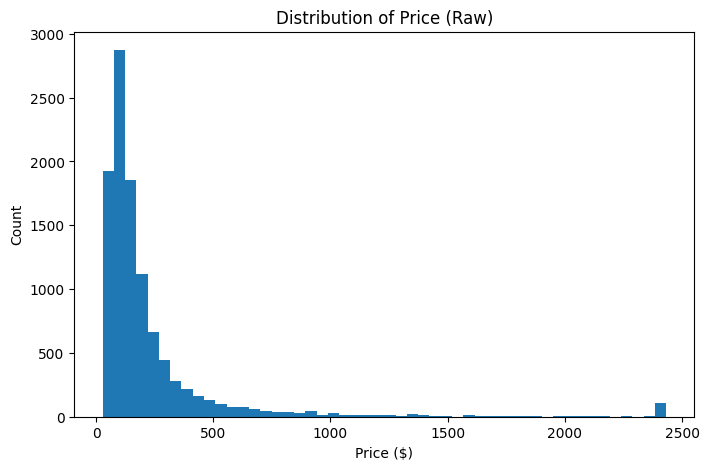

In [93]:
plt.figure(figsize=(8,5))
plt.hist(df["price"], bins=50)
plt.title("Distribution of Price (Raw)")
plt.xlabel("Price ($)")
plt.ylabel("Count")
plt.show()


### Insight: Prices are right-skewed → supports log transform.

In [94]:
#8.2 Price distribution (log)

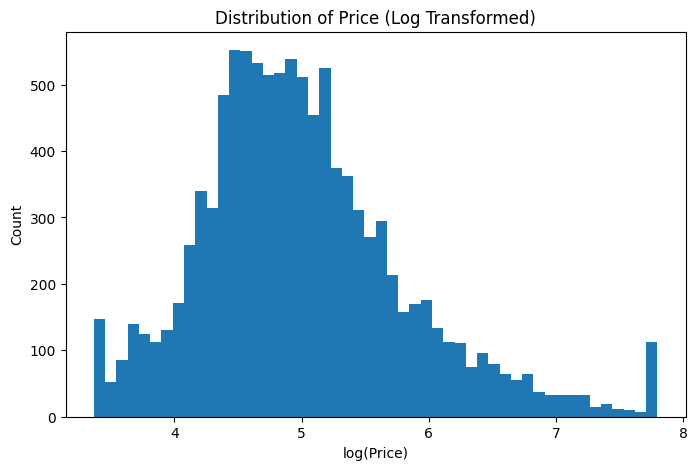

In [95]:
plt.figure(figsize=(8,5))
plt.hist(df["price_log"], bins=50)
plt.title("Distribution of Price (Log Transformed)")
plt.xlabel("log(Price)")
plt.ylabel("Count")
plt.show()


### Insight: Log transform reduces skew and improves model learning.

In [96]:
#8.3 Median price by room type

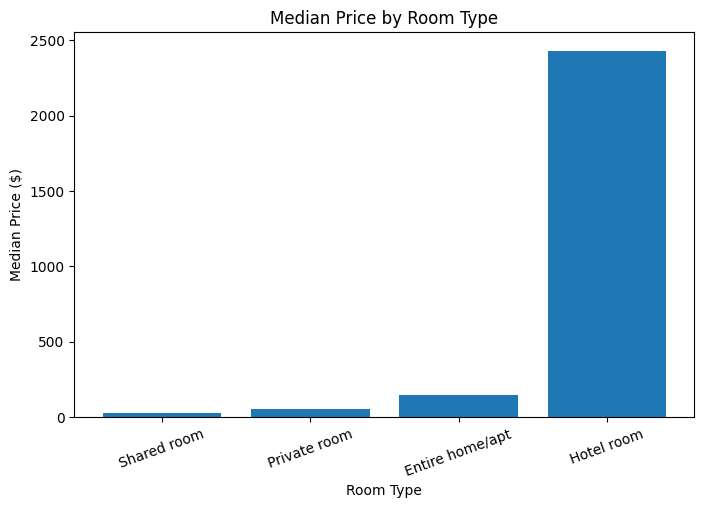

In [97]:
median_price = listing_2.groupby("room_type")["price"].median().sort_values()
plt.figure(figsize=(8,5))
plt.bar(median_price.index, median_price.values)
plt.title("Median Price by Room Type")
plt.xlabel("Room Type")
plt.ylabel("Median Price ($)")
plt.xticks(rotation=20)
plt.show()


### Insight: Room type is a primary price driver.

Insight: Room type is a primary price driver.

In [98]:
#8.4 Minimum nights vs price (zoomed)

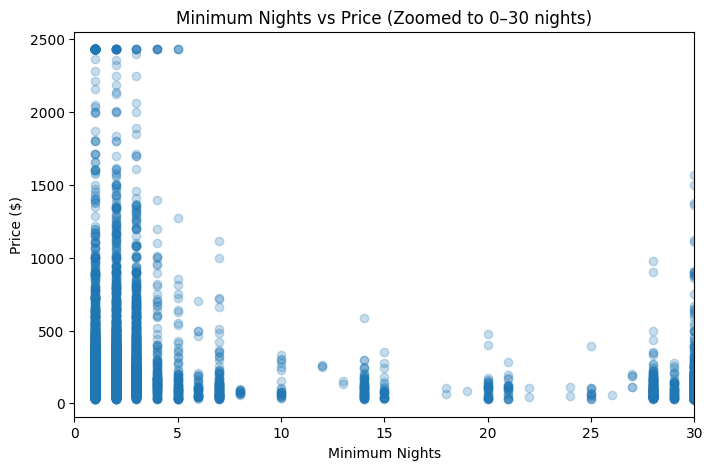

In [99]:
plt.figure(figsize=(8,5))
plt.scatter(df["minimum_nights"], df["price"], alpha=0.25)
plt.xlim(0, 30)
plt.title("Minimum Nights vs Price (Zoomed to 0–30 nights)")
plt.xlabel("Minimum Nights")
plt.ylabel("Price ($)")
plt.show()


Insight: Longer minimum stays often correspond to different pricing strategy.

In [100]:
# 8.5 Location vs price (geo scatter)

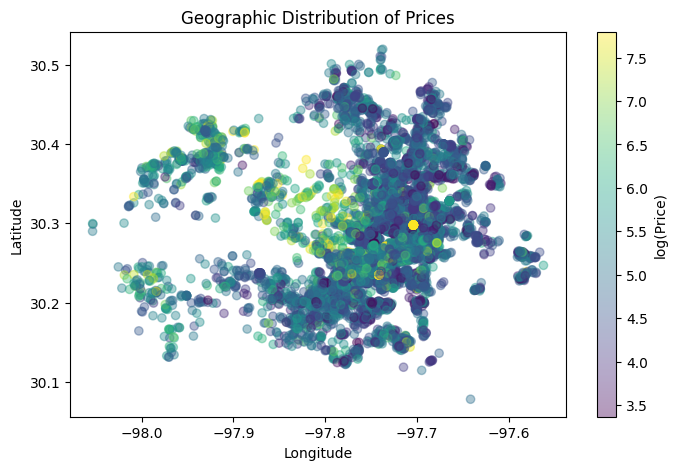

In [101]:
plt.figure(figsize=(8,5))
plt.scatter(
    listing_2["longitude"],
    listing_2["latitude"],
    c=np.log1p(listing_2["price"]),
    alpha=0.4
)
plt.colorbar(label="log(Price)")
plt.title("Geographic Distribution of Prices")
plt.xlabel("Longitude")
plt.ylabel("Latitude")
plt.show()

Insight: Spatial clusters indicate location-based price premiums.

9) Baseline Model: Linear Regression

In [102]:
lr = LinearRegression()
lr.fit(X_train, y_train)

lr_preds = lr.predict(X_test)

lr_rmse = mean_squared_error(y_test, lr_preds)
lr_r2   = r2_score(y_test, lr_preds)

print("Linear Regression RMSE (log):", lr_rmse)
print("Linear Regression R2 (log):", lr_r2)

Linear Regression RMSE (log): 0.5201684484274071
Linear Regression R2 (log): 0.23580904463254393


Insight: Linear regression underfits because Airbnb pricing is nonlinear.

In [103]:
# 10) Advanced Model: XGBoost

In [104]:
xgb = XGBRegressor(
    n_estimators=400,
    max_depth=6,
    learning_rate=0.05,
    subsample=0.8,
    colsample_bytree=0.8,
    random_state=42
)

xgb.fit(X_train, y_train)
xgb_preds = xgb.predict(X_test)

xgb_rmse = mean_squared_error(y_test, xgb_preds)
xgb_r2   = r2_score(y_test, xgb_preds)

print("XGBoost RMSE (log):", xgb_rmse)
print("XGBoost R2 (log):", xgb_r2)

XGBoost RMSE (log): 0.30989680092271893
XGBoost R2 (log): 0.5447237657754616


In [105]:
# Insight: Tree-based model captures interactions and nonlinear patterns → large performance improvement.

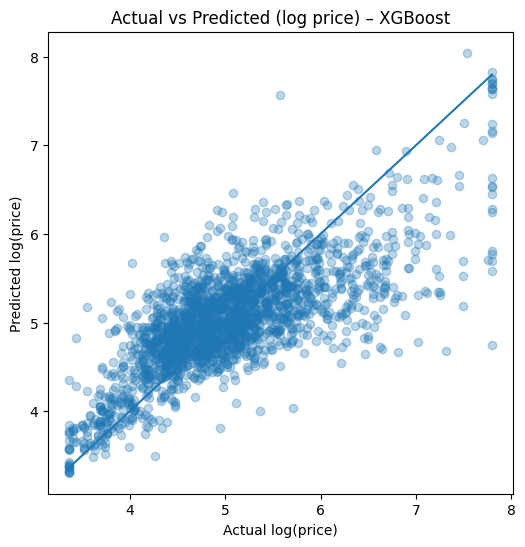

In [106]:
plt.figure(figsize=(6,6))
plt.scatter(y_test, xgb_preds, alpha=0.3)
plt.plot([y_test.min(), y_test.max()], [y_test.min(), y_test.max()])
plt.title("Actual vs Predicted (log price) – XGBoost")
plt.xlabel("Actual log(price)")
plt.ylabel("Predicted log(price)")
plt.show()

Insight: Closer to diagonal = better generalization; outliers show where model struggles (luxury listings).

In [107]:
# 12) Feature Importance (XGBoost)

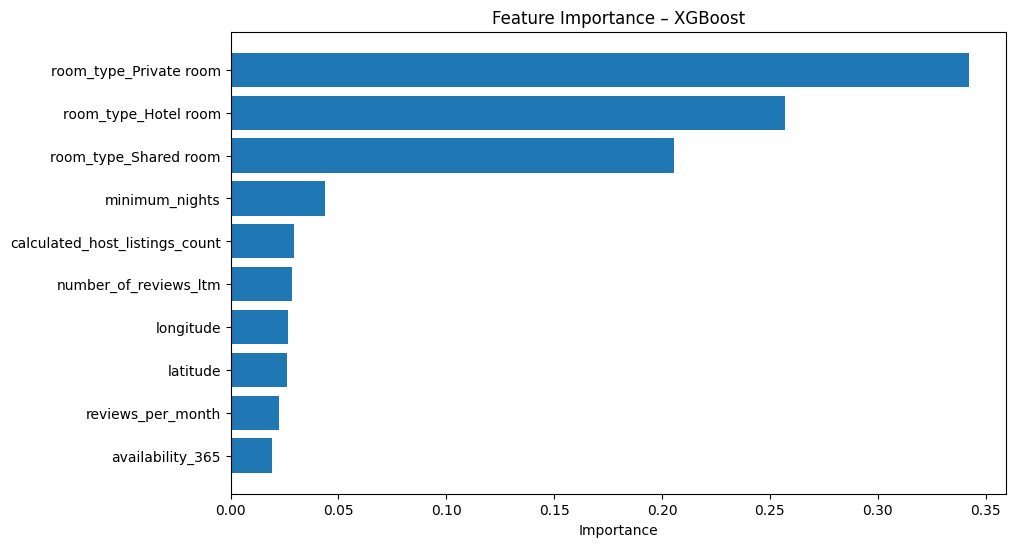

In [108]:
importances = xgb.feature_importances_
fi = pd.DataFrame({"feature": X.columns, "importance": importances}).sort_values("importance")

plt.figure(figsize=(10,6))
plt.barh(fi["feature"], fi["importance"])
plt.title("Feature Importance – XGBoost")
plt.xlabel("Importance")
plt.show()

Insight: Convert the top 5 features into business interpretation.

In [109]:
# 13) Business Insights (Write as bullets)

In [110]:
# Top neighborhoods by median price (using neighbourhood code)
top_neigh = listing_2.groupby("neighbourhood")["price"].median().sort_values(ascending=False).head(10)
top_neigh

neighbourhood
78730    423.0
78746    390.0
78732    273.5
78733    249.0
78734    225.0
78701    212.5
78737    172.5
78703    163.0
78738    157.0
78704    151.0
Name: price, dtype: float64

In [111]:
# Room type counts
listing_2["room_type"].value_counts()


room_type
Entire home/apt    9078
Private room       1300
Hotel room           74
Shared room          65
Name: count, dtype: int64

# 14) Recommendations


## For Hosts

If you have high minimum_nights, consider whether it reduces booking volume; test lower min nights during low season.

Private-room hosts should compete on value and review velocity; entire-home hosts can target premium segments.

## For Platform

Offer dynamic pricing suggestions using nonlinear models (XGBoost-style).

Use location clusters + room type to recommend pricing bands per neighborhood.

In [112]:
# 15) Save Outputs 

In [113]:
fi.sort_values("importance", ascending=False).to_csv("feature_importance_xgb.csv", index=False)
